In [1]:
import numpy as np

import pandas as pd

import seaborn as sns
import  matplotlib.pyplot as plt

from lib.mcalc import gcf2ann, spike2bin, spikeCoin
from lib.mviz import visSpk, visCurve

### Temporal correlation

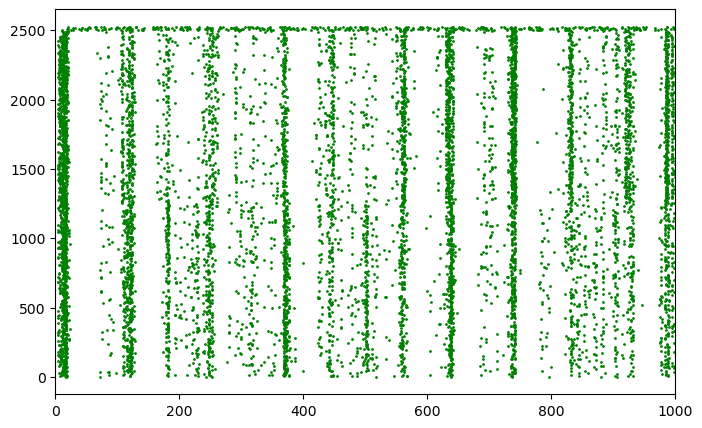

[ 2.74125  2.71     2.79     3.31     3.3      3.095   16.2    ]


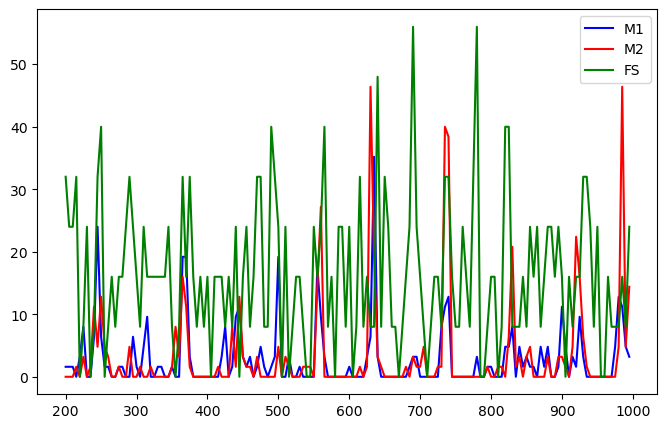

[ 2.79  3.31 16.2 ]


In [2]:
# data setting
Nm = 1250
nMSN = Nm // 10
epoch = 1
T, dt = 1000, 0.1

Nf = 25
D = 2.0
W = 0.5
B = 0.5

recpath = './data/cor-D%.1f'%D
label = '/Nf%d-W%s-B%s/'%(Nf, W, B)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

colors = ['green']
# colors = ['blue', 'red', 'green']

plt.figure(figsize=(8, 5))
for e, c in enumerate(colors): 
    ta, tb = e*T, (e+1)*T
    idx = (ts>=ta) & (ts<tb)
    plt.scatter(ts[idx]-ta, es[idx], s=1, c=c)
    plt.xlim(0, T)
plt.show()

nNums = [Nm, Nm, Nf]
labels = ['M1', 'M2', 'FS']
cs = ['blue', 'red', 'green']

plt.figure(figsize=(8, 5))
binsize = 5
for e, c in enumerate(colors):
    ta, tb = e*T, (e+1)*T
    idx = (ts>=ta) & (ts<tb)

    idBins = np.array([0, Nm-2*nMSN, Nm-nMSN, Nm, Nm+nMSN, Nm+2*nMSN, 2*Nm, 2*Nm+Nf]) + 1
    tmBins = np.arange(200, T+1, binsize)
    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] * 1e3 / binsize
    print(rates.mean(axis=0)/np.array([Nm-2*nMSN, nMSN, nMSN, nMSN, nMSN, Nm-2*nMSN, Nf]))
    rates = rates[:, np.array([2, 3, -1])]
    rates = rates/np.array([nMSN, nMSN, Nf])
    
    tms = tmBins[:-1] + e*T
    xs, ys = [tms]*len(nNums), rates.T
    for x, y, c in zip(xs, ys, cs):
        plt.plot(x, y, c=c)
plt.legend(labels)
plt.show()

print(np.mean(rates, axis=0))

In [3]:
# data setting
Nm = 1250
nMSN = Nm // 10
epoch = 10
T, dt = 2500, 0.1

# range of parameters
Nfs = [0, 25, 30, 50, 90, 150, 250]
# Ws = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5]
# Ws = [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
Ws = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
Bs = [0.1, 0.3, 0.5, 0.7, 0.9]
D = 2.0

recpath = './data/cor-D%.1f'%D

# extract data from raw recordings
frames = []
binKernel = np.ones(int(5 / dt))
grpsize = 10
binsize = 20
for Nf in Nfs:
    if Nf > 0:
        nNums = [Nm, Nm, Nf]
    else:
        nNums = [Nm, Nm, 1]
    for W in Ws:
        for B in Bs:
            label = '/Nf%d-W%s-B%s/'%(Nf, W, B)
            data = np.load(recpath + label + 'spk.npz')
            es, ts = data.f.arr_0, data.f.arr_1
            data.close()

            # processing data
            rates = []
            corrs = []
            for e in range(epoch):
                ta, tb = e*T+500, (e+1)*T
                idx = (ts>=ta) & (ts<tb) & (es>=Nm-nMSN) & (es<=Nm+nMSN)

                idBins = np.arange(Nm-nMSN, Nm+nMSN+1, grpsize)
                tmBins = np.arange(0, T+1-500, binsize)
                rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0]*1e3/binsize/grpsize)

                coV = np.corrcoef(rates[-1].T)
                np.fill_diagonal(coV, 0.)

                # set invalid values to zero
                coV[np.isnan(coV)] = 0

                ng = int(nMSN/grpsize)
                ix = np.arange(0, ng)
                corrs.append([   (np.sum(coV[np.ix_(ix, ix)])/ng/(ng-1) + np.sum(coV[np.ix_(ix+ng, ix+ng)])/ng/(ng-1))/2,
                                np.sum(coV[np.ix_(ix, ix+ng)])/ng/ng])

            # output correlations
            corrs = np.array(corrs)
            frames.append([Nf, W, B, corrs[:,0].tolist(), corrs[:,1].tolist()])

colname = ['Nf', 'Win', 'Bin', 'Wout', 'Bout']
stats = pd.DataFrame(frames, columns=colname)
stats.to_csv('./exp/cor/stats-D%.1f.csv'%D, index=False)

(10, 55) (10, 55)


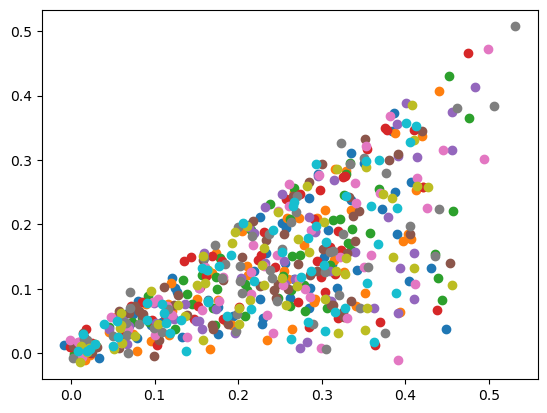

In [4]:
D = 2.0
stats = pd.read_csv('./exp/cor/stats-D%.1f.csv'%D)

import ast
def string_to_np_array(string):
    return np.array(ast.literal_eval(string))
stats['Wout'] = stats['Wout'].apply(string_to_np_array)
stats['Bout'] = stats['Bout'].apply(string_to_np_array)

cors = stats[['Nf', 'Wout', 'Bout']]
va = 0
wa, ba = cors.loc[cors['Nf']==va, 'Wout'], cors.loc[cors['Nf']==va, 'Bout']
wa = np.stack(wa).transpose()
ba = np.stack(ba).transpose()
print(wa.shape, ba.shape)
for i in range(wa.shape[0]):
    plt.scatter(wa[i], ba[i], marker='o', label=r'$N_{fsi}=0$')

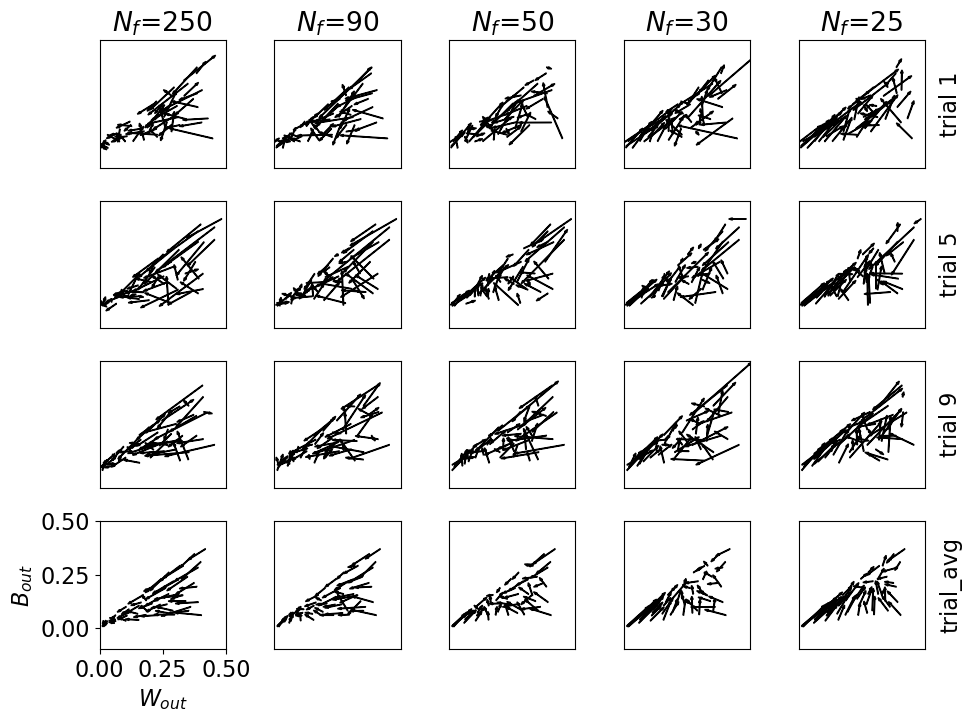

In [12]:
# plot font size
plt.rcParams.update({'font.size': 16})

Nfsl = [250, 90, 50, 30, 25]
eps = [0, 4, 8]
xmax, ymax = 0.5, 0.5

fig,axes = plt.subplots(len(eps)+1, len(Nfsl), figsize=(2.5*(len(Nfsl)-1), 2.5*len(eps)))

for j, vb in enumerate(Nfsl):
    wb, bb = cors.loc[cors['Nf']==vb, 'Wout'], cors.loc[cors['Nf']==vb, 'Bout']
    wb = np.stack(wb).transpose()
    bb = np.stack(bb).transpose()

    for i, idx in enumerate(eps):
        ax = axes[i,j]
        if i == 0:
            ax.set_title(r'$N_f$=%d'%vb)
        
        # axis label
        if j == len(Nfsl)-1:
            ax.yaxis.set_label_position("right")
            ax.yaxis.labelpad = 10
            ax.yaxis.tick_right()
            ax.set_yticks([])
            # ax.set_ylabel(r'$\delta=$%.1fHz'%(idx*0.2))
            ax.set_ylabel('trial %d'%(idx+1))
        else:
            ax.set_yticks([])
        ax.set_xticks([])

        # xy range
        ax.set_xlim(0, xmax)
        ax.set_ylim(-0.1, ymax)

        # plot
        for x, y, xx, yy in zip(wa[idx], ba[idx], wb[idx], bb[idx]):
            ax.arrow(x, y, xx-x, yy-y, width=xmax/200, head_width=xmax/50, edgecolor=None, facecolor='k', alpha=1.0);

    ax = axes[len(eps), j]
    for x, y, xx, yy in zip(np.mean(wa,axis=0), np.mean(ba,axis=0), np.mean(wb,axis=0), np.mean(bb,axis=0)):
        ax.arrow(x, y, xx-x, yy-y, width=xmax/200, head_width=xmax/50, edgecolor=None, facecolor='k', alpha=1.0);
    # xy range
    ax.set_xlim(0, xmax)
    ax.set_ylim(-0.1, ymax)
    if j == 0:
        # ax.set_xlabel(r'$c_w^{out}$') 
        # ax.set_ylabel(r'$c_b^{out}$')
        ax.set_xlabel(r'$W_{out}$')
        ax.set_ylabel(r'$B_{out}$')
        ax.set_xticks([0, xmax/2, xmax])
        ax.set_yticks([0., ymax/2, ymax])
    elif j == len(Nfsl)-1:
        ax.yaxis.set_label_position("right")
        ax.yaxis.labelpad = 10
        ax.yaxis.tick_right()
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel('trial_avg')
    elif j > 0:
        ax.set_yticks([])
        ax.set_xticks([])
    
plt.tight_layout()
plt.savefig('./plot/cor.pdf', bbox_inches='tight')